# Chamfer Approximation

In this notebook we attempt to approximate the chamfer similarity directly. First, we build an LSH forest for each document and query to find the closest matching vector before taking the dot product. Second, we use an LSH forest that encorporates multiple documents together and perform this same estimation.

Calculate Chamfer Directly:
- Extremely fast in practice
- $O(n^2qd)$. 

Simple LSH Forest
- Slowest in practice
- $O(nq(lk_m + ad + a log(a)))$

The multi-document Forest
- Slightly faster than simple approach above
- $O(nq(lk_m + ad + a log(a)))$

In [ ]:
import matplotlib.pyplot as plt
import sys
import os
import numpy as np
sys.path.append(os.path.abspath("../src"))
from shared.lsh_forest import LSHForest, MultiDocLSHForest, RandomHyperplaneLSH
from shared.utils import chamfer, build_multidoc_lsh, build_simple_lsh, experiment, recall
from shared.plotting import plot, plot_similarity_heatmap

def simple_approximate_best(forests: list[LSHForest], a):
        matches = np.empty((n, q, d), dtype=np.float32)
        for document, forest in enumerate(forests):
                for i, query in enumerate(queries):
                        idx = forest.query(query, a, dist=distance)[0][0]
                        matches[document, i] = forest.data[idx]
        sims = np.tensordot(matches, queries, axes=([1, 2], [0, 1]))
        best_doc = int(np.argmax(sims))
        return float(sims[best_doc]), best_doc

def multidoc_approximate_best(forest: MultiDocLSHForest, a):
        matches = np.empty((n, q, d), dtype=np.float32)
        for i, query in enumerate(queries):
                results = forest.query(query, a, dist=distance)
                for document, result in enumerate(results):
                        idx, _ = result[0]
                        matches[document, i] = forest.data[document][idx]
        sims = np.tensordot(matches, queries, axes=([1, 2], [0, 1]))
        best_doc = int(np.argmax(sims))
        return float(sims[best_doc]), best_doc


n = 10                                 # number of documents
q = 25                                  # vectors per query
m = 64                                  # vectors per document
d = 16                                  # dimension per vector
l = 10                                  # trees per forest
k = 20                                  # pivots to keep per node in tree
km = 64                                 # max depth of each tree
a = 15                                  # number of neighbors to retrieve per query
rng = np.random.default_rng(42)
distance = lambda a, b: -np.dot(a, b)
defaults = dict(l=l, k=k, km=km, a=a)

experiments = {
        'l':  [1, 4, 8, 16, 32],
        'k':  [4, 8, 16, 32, 64],
        'km': [16, 32, 64, 128, 256],
        'a':  [1, 4, 8, 16, 32]
}


In [8]:
# Creating Simulated Data with Similarity Dropoff
# Create a base document
base_doc = rng.normal(size=(m, d)).astype(np.float32)
base_doc /= np.linalg.norm(base_doc, axis=-1, keepdims=True)

# Query = a noisy subset of the base document (with reordering and dropout)
query_indices = rng.choice(m, size=q, replace=False)
queries = base_doc[query_indices] + 0.1 * rng.normal(size=(q, d))  # small noise
queries /= np.linalg.norm(queries, axis=-1, keepdims=True)

def make_noisy_doc(base_doc, noise_scale):
    noise = rng.normal(size=base_doc.shape).astype(np.float32)
    corrupted = base_doc + noise_scale * noise
    corrupted /= np.linalg.norm(corrupted, axis=-1, keepdims=True)
    return corrupted

# Insert the base_doc as the first "perfect" match
vectors = np.empty((n, m, d), dtype=np.float32)
vectors[0] = base_doc

# Gradually increasing noise
max_noise = 0.5
for i in range(1, n):
    alpha = i / (n - 1)  # smoothly ramps from 0 to 1
    noise_scale = alpha * max_noise
    vectors[i] = make_noisy_doc(base_doc, noise_scale)

# Normalize
base_doc /= np.linalg.norm(base_doc, axis=-1, keepdims=True)
queries /= np.linalg.norm(queries, axis=-1, keepdims=True)

# Baseline
best = (0, 0)
for document, doc_vecs in enumerate(vectors):
        sim = chamfer(queries, doc_vecs)
        if sim >= best[0]:
                best = (float(sim), document)
print(queries.shape)
print(vectors.shape)
print(best)

(25, 16)
(100, 64, 16)
(23.42077954190897, 1)


In [9]:
# Constructors for each forest type
def build_simple_lsh(l, k, km):
        single_doc_forests = [LSHForest(RandomHyperplaneLSH(d), l, k, km) for _ in range(n)]
        for doc, forest in enumerate(single_doc_forests):
                forest.batch_insert(vectors[doc])
        return single_doc_forests

def build_multidoc_lsh(l, k, km):
        multi_doc_forest = MultiDocLSHForest(RandomHyperplaneLSH(d), l, k, km)
        multi_doc_forest.batch_insert(vectors)
        return multi_doc_forest

simple_approximate_best took 0.1225 sec, 375 vector comparisons (approx)

simple_approximate_best took 0.3470 sec, 375 vector comparisons (approx)

simple_approximate_best took 0.4865 sec, 375 vector comparisons (approx)

simple_approximate_best took 0.7787 sec, 375 vector comparisons (approx)

simple_approximate_best took 1.3714 sec, 375 vector comparisons (approx)

Finished experiment: l


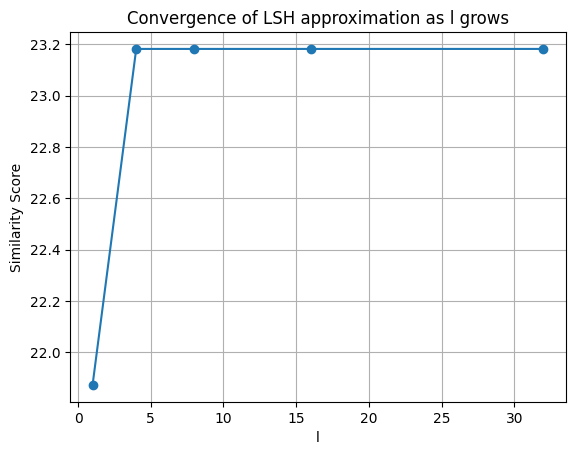

Best l = 4 → doc #1


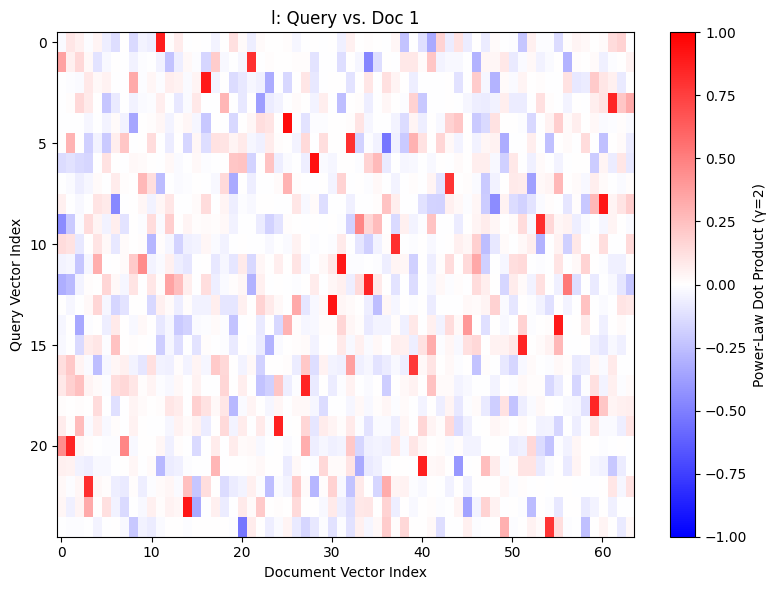

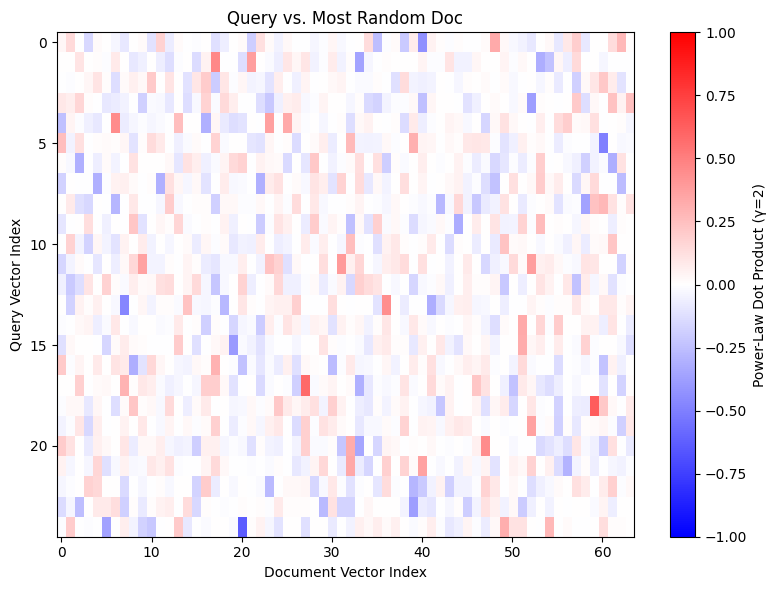

simple_approximate_best took 0.4694 sec, 375 vector comparisons (approx)

simple_approximate_best took 0.5012 sec, 375 vector comparisons (approx)

simple_approximate_best took 0.5414 sec, 375 vector comparisons (approx)

simple_approximate_best took 0.5550 sec, 375 vector comparisons (approx)

simple_approximate_best took 0.5992 sec, 375 vector comparisons (approx)

Finished experiment: k


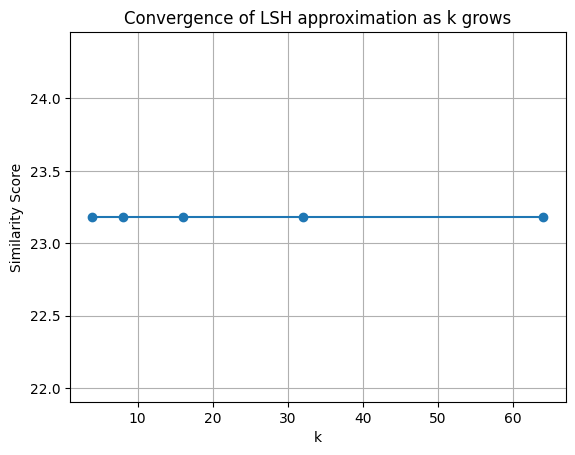

Best k = 4 → doc #1


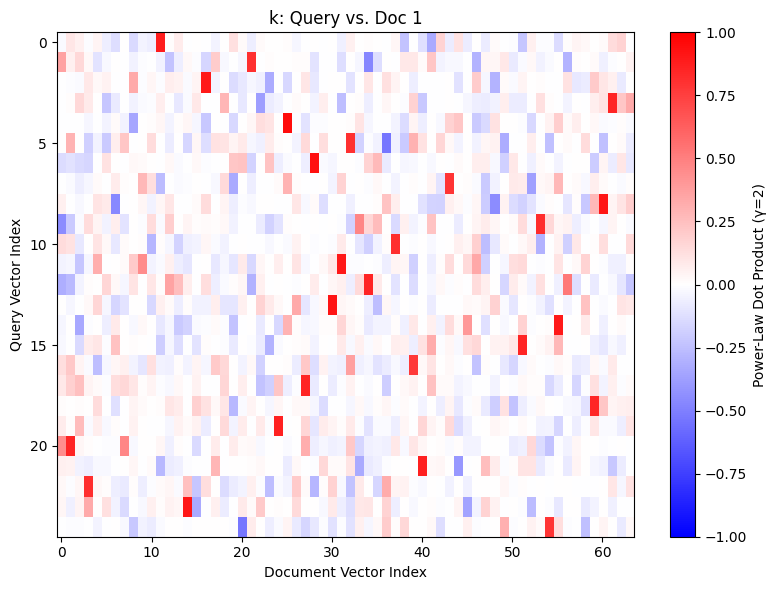

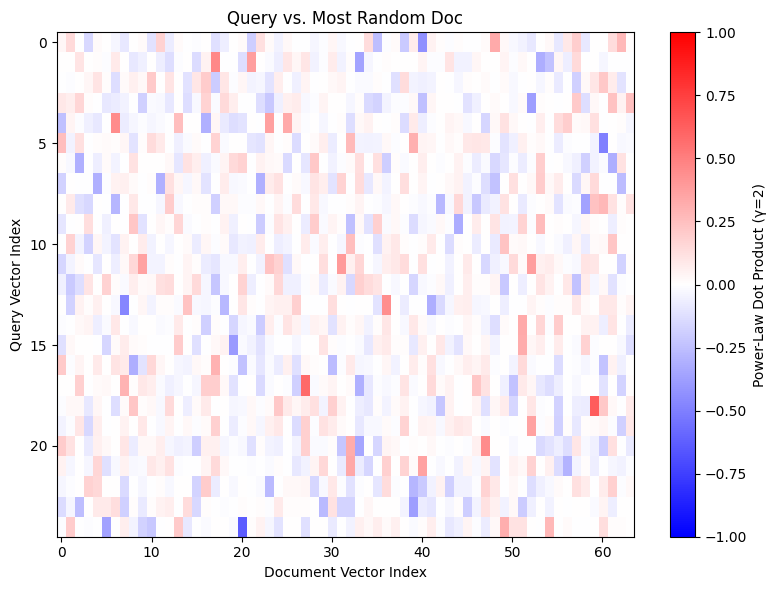

simple_approximate_best took 0.5322 sec, 375 vector comparisons (approx)

simple_approximate_best took 0.5185 sec, 375 vector comparisons (approx)

simple_approximate_best took 0.5396 sec, 375 vector comparisons (approx)

simple_approximate_best took 0.5306 sec, 375 vector comparisons (approx)

simple_approximate_best took 0.5525 sec, 375 vector comparisons (approx)

Finished experiment: km


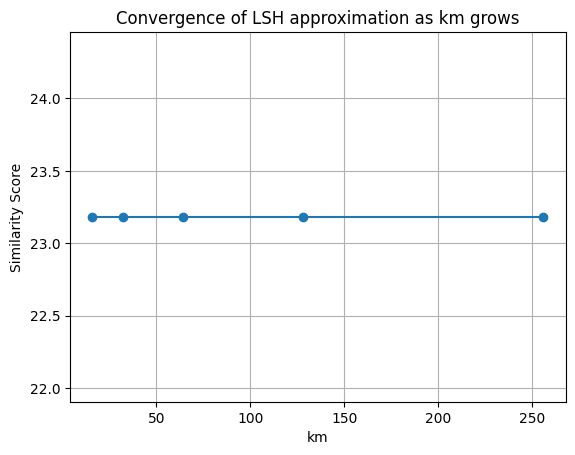

Best km = 16 → doc #1


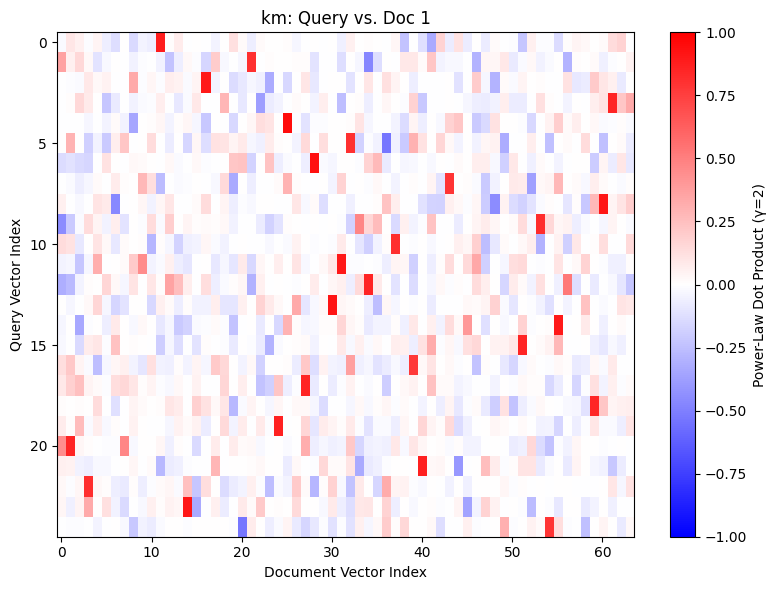

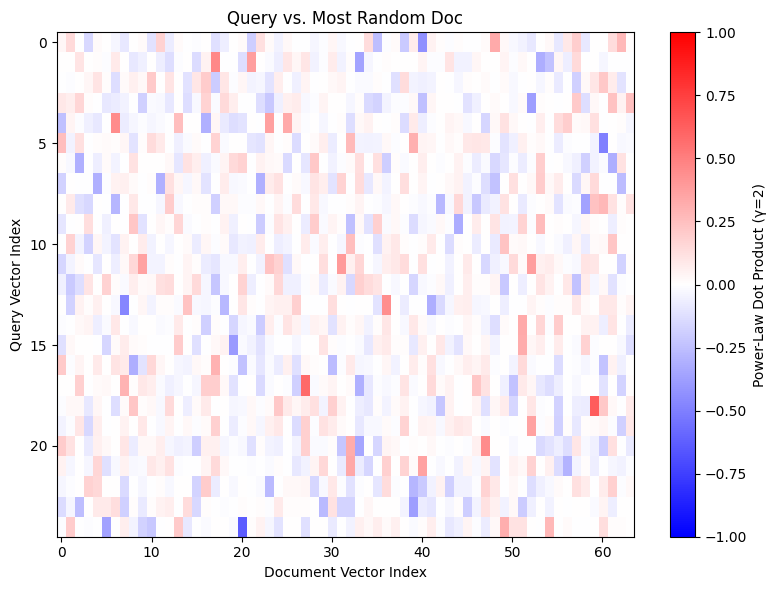

simple_approximate_best took 0.5165 sec, 25 vector comparisons (approx)

simple_approximate_best took 0.5221 sec, 100 vector comparisons (approx)

simple_approximate_best took 0.5145 sec, 200 vector comparisons (approx)

simple_approximate_best took 0.5141 sec, 400 vector comparisons (approx)

simple_approximate_best took 0.5184 sec, 800 vector comparisons (approx)

Finished experiment: a


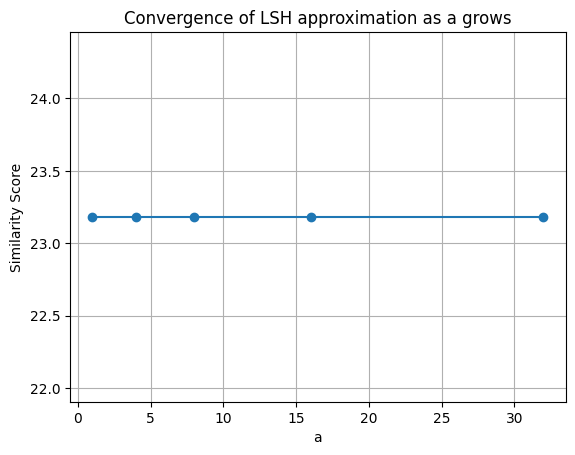

Best a = 1 → doc #1


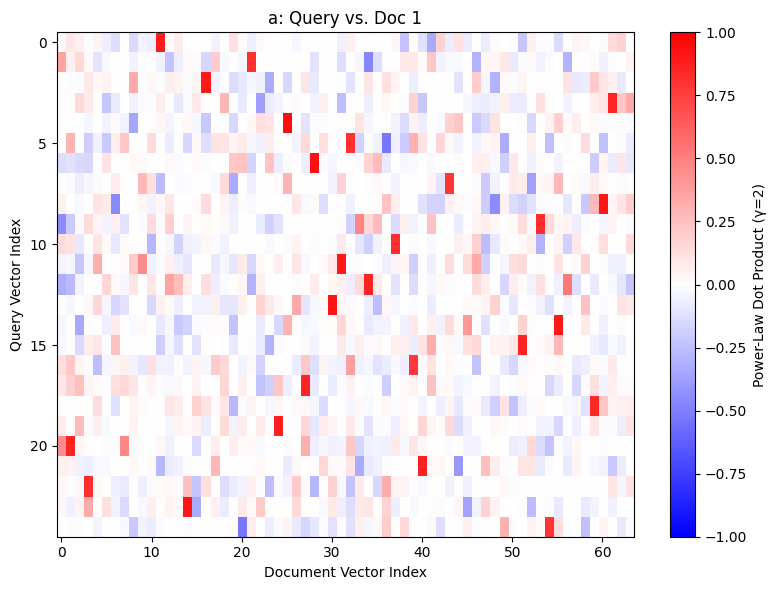

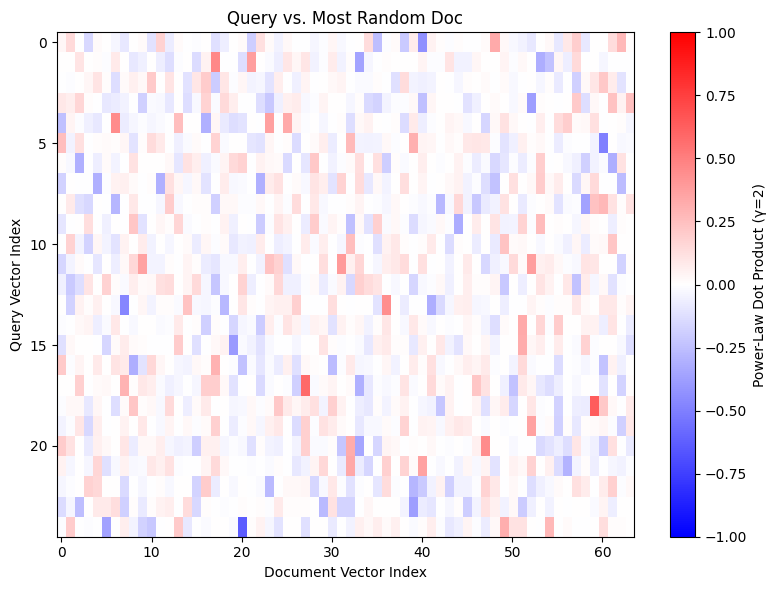

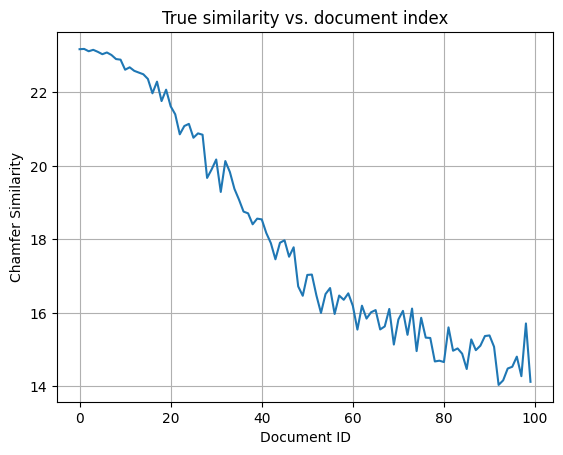

In [3]:
# Evaluate single-doc
results = {}
for var, vals in experiments.items():
    sims, docs = experiment(var, vals, defaults, build_simple_lsh, simple_approximate_best)
    results[var] = (sims, docs)
    plot(experiments[var], sims, xlabel=f'{var}')
    
    # Pick the best result and visualize
    best_index = int(np.argmax(sims))
    best_doc_index = docs[best_index]
    print(f"Best {var} = {vals[best_index]} → doc #{best_doc_index}")
    plot_similarity_heatmap(queries, vectors[best_doc_index],
                            title=f"{var}: Query vs. Doc {best_doc_index}")
    plot_similarity_heatmap(queries, vectors[-1], f"Query vs. Most Random Doc")

sims = [chamfer(queries, doc) for doc in vectors]
plt.plot(sims)
plt.xlabel("Document ID")
plt.ylabel("Chamfer Similarity")
plt.title("True similarity vs. document index")
plt.grid(True)
plt.show()


multidoc_approximate_best took 0.0690 sec, 375 vector comparisons (approx)

multidoc_approximate_best took 0.1297 sec, 375 vector comparisons (approx)

multidoc_approximate_best took 0.1824 sec, 375 vector comparisons (approx)

multidoc_approximate_best took 0.2890 sec, 375 vector comparisons (approx)

multidoc_approximate_best took 0.5593 sec, 375 vector comparisons (approx)

Finished experiment: l


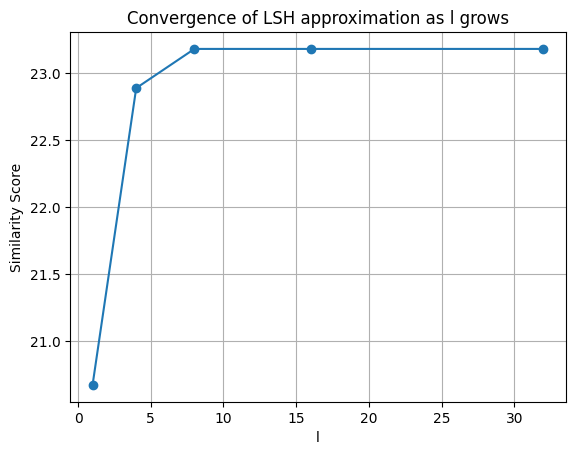

Best l = 8 → doc #1


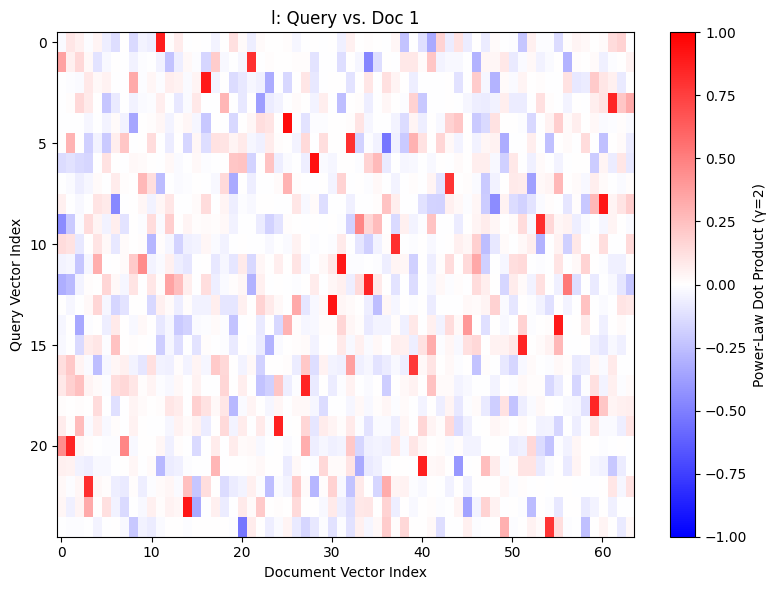

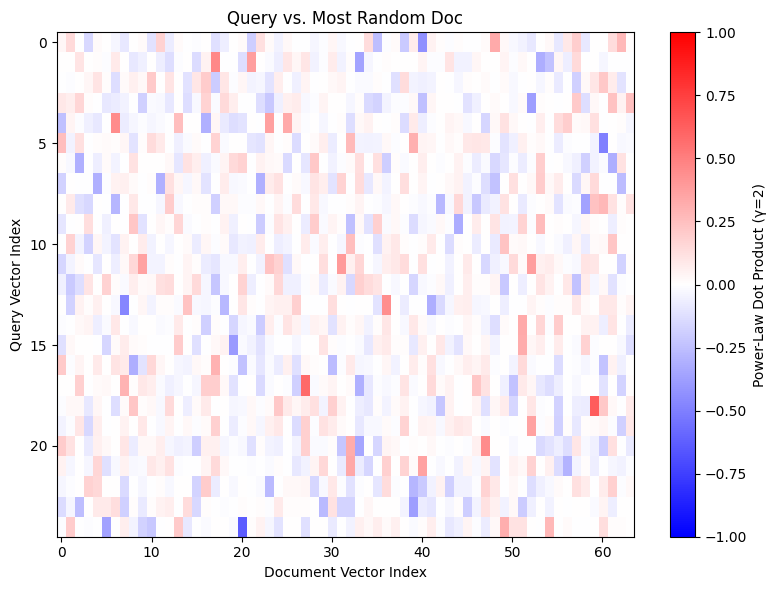

multidoc_approximate_best took 0.2152 sec, 375 vector comparisons (approx)

multidoc_approximate_best took 0.2157 sec, 375 vector comparisons (approx)

multidoc_approximate_best took 0.2388 sec, 375 vector comparisons (approx)

multidoc_approximate_best took 0.2177 sec, 375 vector comparisons (approx)

multidoc_approximate_best took 0.2250 sec, 375 vector comparisons (approx)

Finished experiment: k


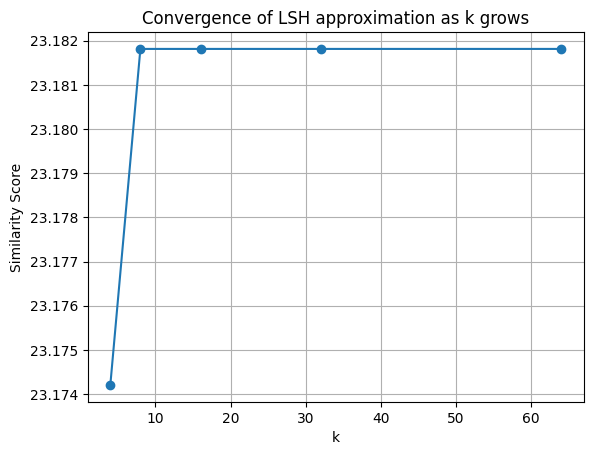

Best k = 8 → doc #1


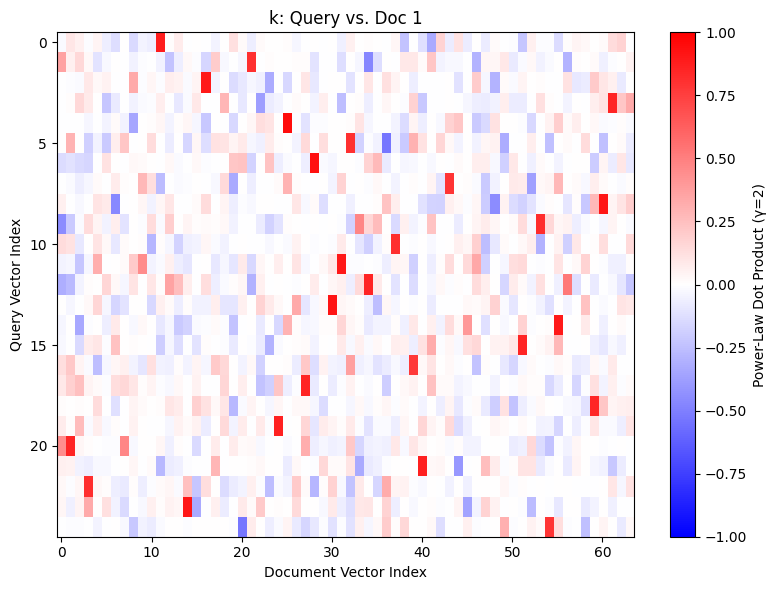

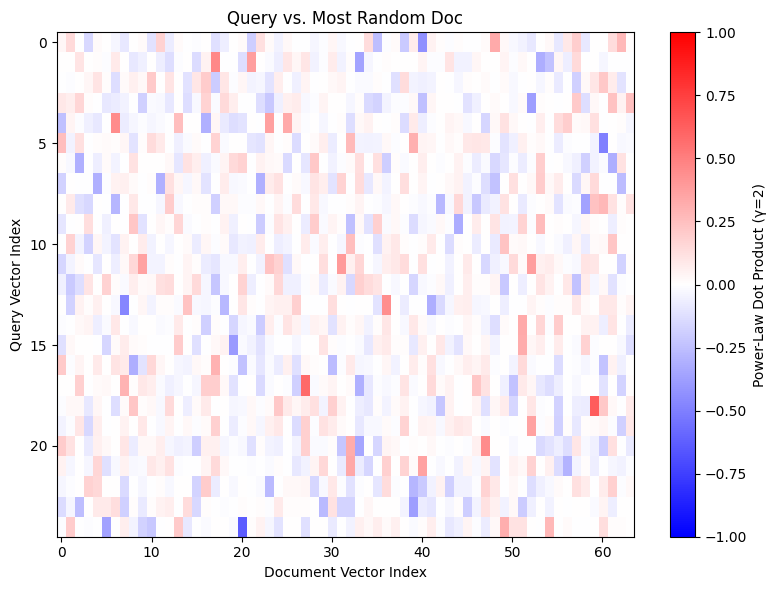

multidoc_approximate_best took 0.1791 sec, 375 vector comparisons (approx)

multidoc_approximate_best took 0.2187 sec, 375 vector comparisons (approx)

multidoc_approximate_best took 0.2403 sec, 375 vector comparisons (approx)

multidoc_approximate_best took 0.2122 sec, 375 vector comparisons (approx)

multidoc_approximate_best took 0.3077 sec, 375 vector comparisons (approx)

Finished experiment: km


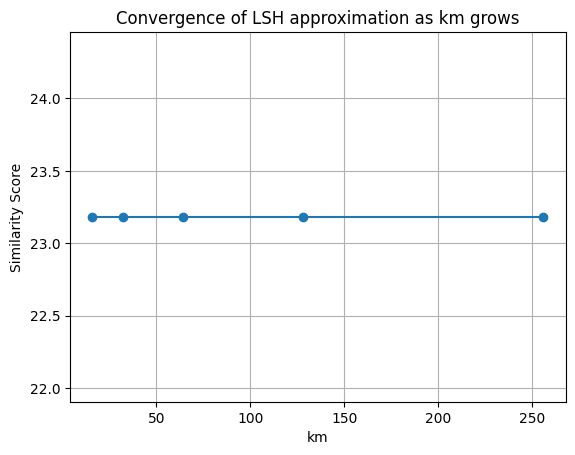

Best km = 16 → doc #1


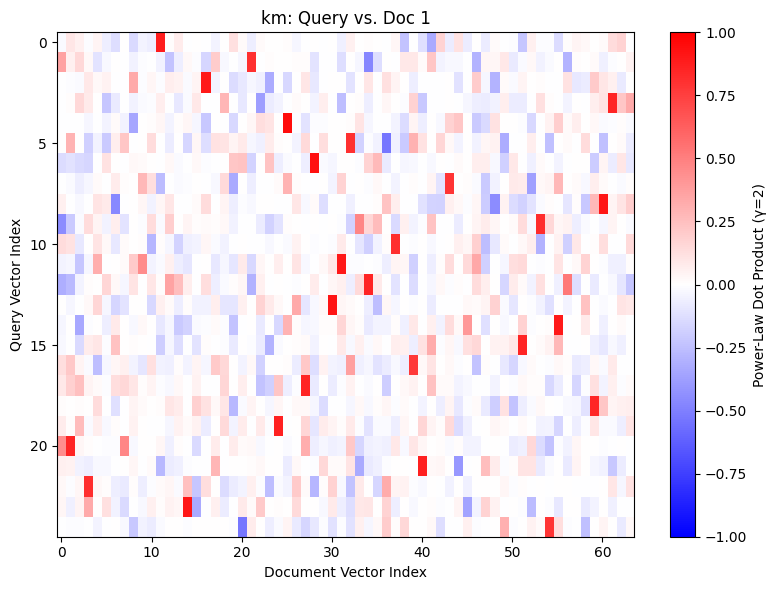

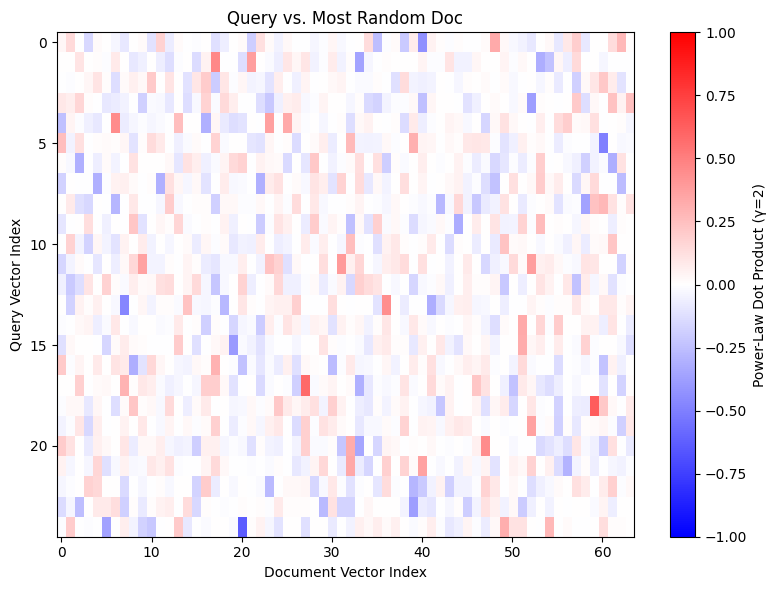

multidoc_approximate_best took 0.0867 sec, 25 vector comparisons (approx)

multidoc_approximate_best took 0.1360 sec, 100 vector comparisons (approx)

multidoc_approximate_best took 0.1717 sec, 200 vector comparisons (approx)

multidoc_approximate_best took 0.2365 sec, 400 vector comparisons (approx)

multidoc_approximate_best took 0.3008 sec, 800 vector comparisons (approx)

Finished experiment: a


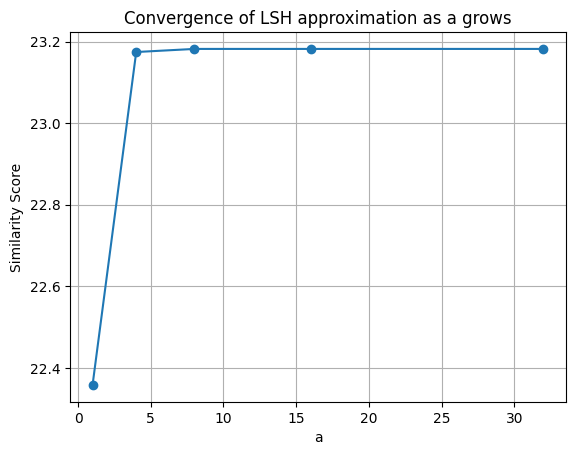

Best a = 8 → doc #1


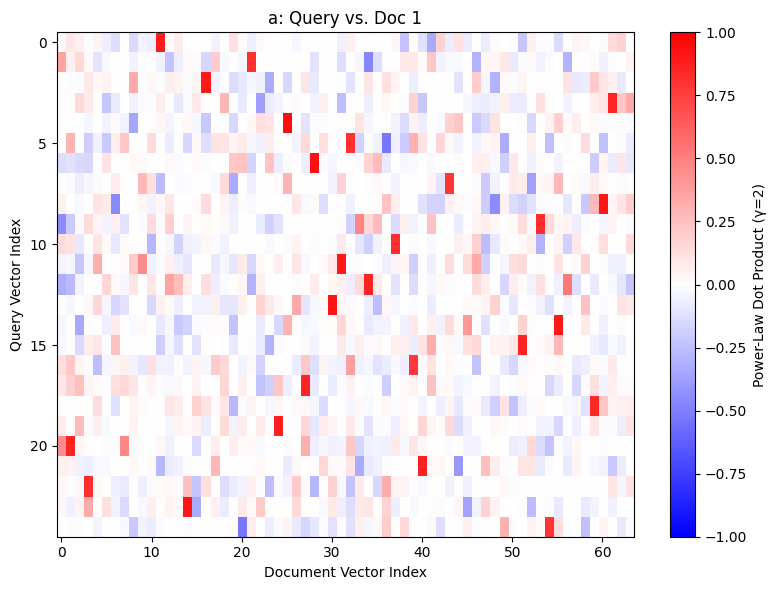

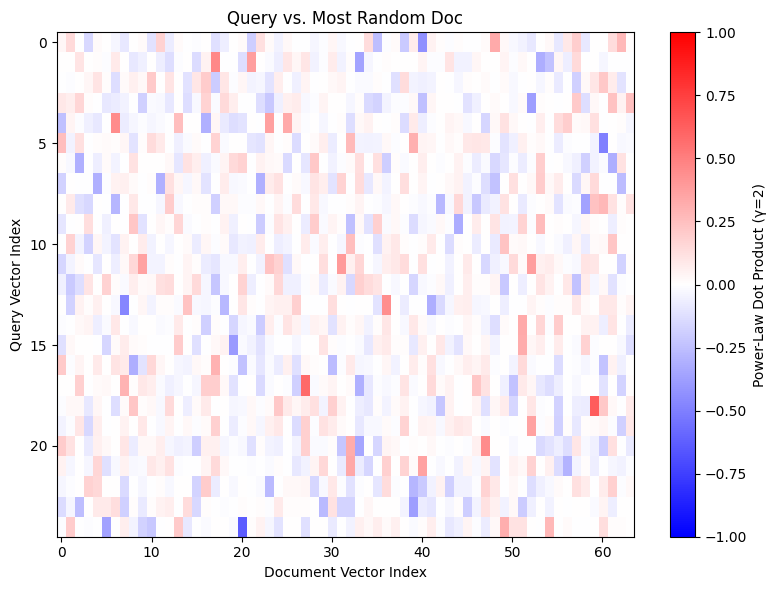

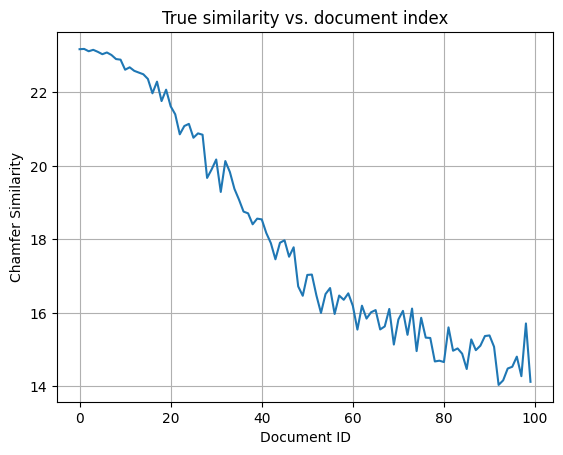

In [4]:

# Evaluate multi-doc
results = {}
for var, vals in experiments.items():
    sims, docs = experiment(var, vals, defaults, build_multidoc_lsh, multidoc_approximate_best)
    results[var] = (sims, docs)
    plot(experiments[var], sims, xlabel=f'{var}')
    
    # Pick the best result and visualize
    best_index = int(np.argmax(sims))
    best_doc_index = docs[best_index]
    print(f"Best {var} = {vals[best_index]} → doc #{best_doc_index}")
    plot_similarity_heatmap(queries, vectors[best_doc_index],
                            title=f"{var}: Query vs. Doc {best_doc_index}")
    plot_similarity_heatmap(queries, vectors[-1], f"Query vs. Most Random Doc")

sims = [chamfer(queries, doc) for doc in vectors]
plt.plot(sims)
plt.xlabel("Document ID")
plt.ylabel("Chamfer Similarity")
plt.title("True similarity vs. document index")
plt.grid(True)
plt.show()
